<a href="https://colab.research.google.com/github/MosaicGroupCMU/African-MRS-Tutorials/blob/main/Google-Colab/Answers/5_QE_Vibrational_Modes_H2_Answers_Full_Install.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Quantum ESPRESSO and ASE

**Run the cell below at the start of today's class to install QE and ASE.**

NOTE: Quantum ESPRESSO installation takes ~8 minutes. ASE installation takes ~3 minutes.

In [ ]:
# eliminate text output during installation
%%capture

# install mathematical libraries to peform fast Fourier transforms
!apt-get install -y libfftw3-3 libfftw3-dev libfftw3-doc

In [ ]:
%%capture

# navigate to main directory named '/content/'
%cd /content/

# download the pre-compiled files in compressed format (under Linux)
#! wget 'https://docs.google.com/uc?export=download&id=1kw_CJMjP6ggDZXDNp5phAqCPpoe2WXCA' -O qe-lite.tgz
!gdown 'https://drive.google.com/uc?export=download&id=13l-Kiyg-F6aYb5lF8M3RsE1hSnLRdGna' -O qe-lite.tgz

# unpack the compressed files (under Linux)
! tar -xvzf qe-lite.tgz

# clean up some files
! rm -rf sample_data qe-lite.tgz

In [ ]:
%%capture

# install the Atomic simulation environment - may take ~3 mins
# ! apt install ase
! pip install git+https://gitlab.com/ase/ase

---
# Vibrational modes of molecules

In this tutorial, you will lean how to calculate the vibrational frequencies of molecules from first principles, using molecular hydrogen as an example.

Contributors: [Lorenzo Bastonero](https://github.com/bastonero), [Jessica Wen](https://github.com/JessicaWen-PhD)

# The harmonic approximation

Atoms in molecules and solids vibrate around their _equilibrium_ positions.

![n2harmonicoscillation.png](https://upload.wikimedia.org/wikipedia/commons/a/aa/N2ground.png)

# Setup

This part installs libraries for numerical calculations and plotting.

In [ ]:
import os
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

This part uploads the pseudopotentials needed for our calculations.

In [ ]:
# eliminate text output during installation
%%capture

# create pseudopotentials folder and navigate into it
%mkdir -p /content/q-e/pseudopotentials
%cd /content/q-e/pseudopotentials/

# download the H pseudopotential file from the GitHub
! wget https://raw.githubusercontent.com/MosaicGroupCMU/African-MRS-Tutorials/refs/heads/main/Google-Colab/H.UPF

# navigate to main directory named '/content/'
%cd ../..

# clean up some files
! rm -rf sample_data

## $H_2$ vibrational mode: finite differences of forces

### Step 1: find the _equilibrium_ geometry.

In [ ]:
# Importing required libraries
from ase import Atoms
from ase.visualize import view

# Step 1: Define H2 molecule with bond length
# H-H bond length in Angstroms
bond_length = 0.74

# Create an H2 molecule with two hydrogen atoms
h2_molecule = Atoms('H2', positions=[[0, 0, 0], [0, 0, bond_length]])

# Step 2: Visualize the molecule
view(h2_molecule, viewer='x3d')
# hint: try rotating the molecule and zooming in and out!

In [ ]:
# Optional output: Print details of the H2 molecule
print("H2 Molecule Information:")
print("Atomic Positions (in Angstrom):")
print(h2_molecule.get_positions())
print("Atomic Numbers:", h2_molecule.get_atomic_numbers())
print("Bond Length:", bond_length)

H2 Molecule Information:
Atomic Positions (in Angstrom):
[[0.   0.   0.  ]
 [0.   0.   0.74]]
Atomic Numbers: [1 1]
Bond Length: 0.74


Fill out the base input file (remember definitions can be found [here](https://www.ecosia.org/search?q=quantum+espresso+input+file&addon=chrome&addonversion=6.0.4&method=topbar&addon=opensearch)).

In [ ]:
# create calculation folder and navigate into it
%mkdir -p /content/hydrogen
%cd /content/hydrogen/

# create input and write it into the file h2.scf.in
qe_input = """
&control
  prefix='h2',
  calculation='scf',
  verbosity='high',
  pseudo_dir = '/content/q-e/pseudopotentials/',
  outdir='/content/hydrogen/'
  tstress=false,
  tprnfor=false,
  restart_mode='from_scratch',
/
&system
  occupations='smearing',
  smearing='mv',
  degauss=0.01,
  ecutwfc = 30.0,
  ecutrho = 240.0,
  ibrav = 1,
  celldm(1) = 20,
  nat = 2,
  ntyp = 1,
/
&electrons
  conv_thr = 1e-6,
/
ATOMIC_SPECIES
 H  1.00784  H.UPF
ATOMIC_POSITIONS (angstrom)
 H 0.00 0.00 0.00
 H 1.00 0.00 0.00
K_POINTS (automatic)
  1 1 1 0 0 0
"""

with open("h2.scf.in", "w") as f:
    f.write(qe_input)

# print the content of the input file (under Linux)
! cat h2.scf.in

/content/hydrogen

&control
  prefix='hydrogen',
  calculation='scf',
  verbosity='high',
  pseudo_dir = '/content/q-e/pseudopotentials/',
  outdir='/content/hydrogen/'
  tstress=false,
  tprnfor=false,
  restart_mode='from_scratch',
/
&system
  occupations='smearing',
  smearing='mv',
  degauss=0.01,
  ecutwfc = 30.0,
  ecutrho = 240.0,
  ibrav = 1,
  celldm(1) = 20,
  nat = 2,
  ntyp = 1,
/
&electrons
  conv_thr = 1e-6,
/
ATOMIC_SPECIES
 H  1.00784  H.UPF
ATOMIC_POSITIONS (angstrom)
 H 0.00 0.00 0.00
 H 1.00 0.00 0.00
K_POINTS (automatic)
  1 1 1 0 0 0


Calculate the potential energy surface for different distances of the atoms. We use a similar process to exercise 1 (on finding the minimum energy for different lattice parameters of silicon).

In [ ]:
from ase import io

# create a list for atomic distances to be tested
distances = np.arange(0.3,2.3,0.1) # try from 0.3 to 2.3 angstroms

# find the second hydrogen in the "atomic positions" line in the input file
distance_index = qe_input.find('ATOMIC_POSITIONS') + 49

total_energies = []
for distance in distances:
  # update the input file with the new atomic distance
  new_input_file = qe_input[:distance_index] + "%.2f" % distance + qe_input[distance_index+4:]

  # overwrite the input file
  with open("h2.scf.in", "w") as f:
    f.write(new_input_file)

  ! cat h2.scf.in
  ! /content/q-e/bin/pw.x  -in h2.scf.in > h2.scf.out # run the DFT input file

  output = io.read("/content/hydrogen/h2.scf.out") # read the output file

  total_energies.append(output.get_total_energy()) # record the calculated total energy

energy0 = min(total_energies)
print("The minimum energy is: ", energy0, " eV")


&control
  prefix='hydrogen',
  calculation='scf',
  verbosity='high',
  pseudo_dir = '/content/q-e/pseudopotentials/',
  outdir='/content/hydrogen/'
  tstress=false,
  tprnfor=false,
  restart_mode='from_scratch',
/
&system
  occupations='smearing',
  smearing='mv',
  degauss=0.01,
  ecutwfc = 30.0,
  ecutrho = 240.0,
  ibrav = 1,
  celldm(1) = 20,
  nat = 2,
  ntyp = 1,
/
&electrons
  conv_thr = 1e-6,
/
ATOMIC_SPECIES
 H  1.00784  H.UPF
ATOMIC_POSITIONS (angstrom)
 H 0.00 0.00 0.00
 H  0.30 0.00 0.00
K_POINTS (automatic)
  1 1 1 0 0 0

&control
  prefix='hydrogen',
  calculation='scf',
  verbosity='high',
  pseudo_dir = '/content/q-e/pseudopotentials/',
  outdir='/content/hydrogen/'
  tstress=false,
  tprnfor=false,
  restart_mode='from_scratch',
/
&system
  occupations='smearing',
  smearing='mv',
  degauss=0.01,
  ecutwfc = 30.0,
  ecutrho = 240.0,
  ibrav = 1,
  celldm(1) = 20,
  nat = 2,
  ntyp = 1,
/
&electrons
  conv_thr = 1e-6,
/
ATOMIC_SPECIES
 H  1.00784  H.UPF
ATOMIC_POSIT

Plot the energy variation over different atomic distances.

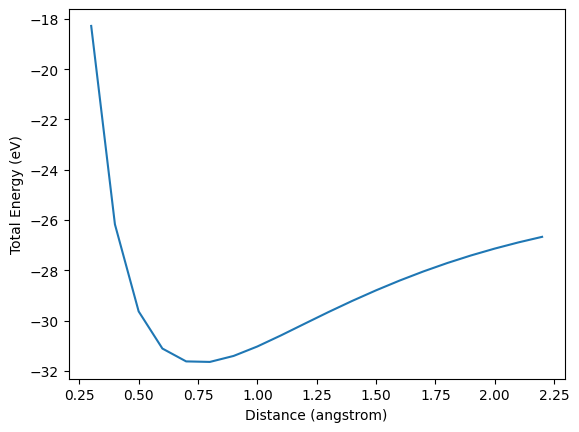

In [ ]:
fig,ax = plt.subplots()
ax.plot(distances, total_energies)
ax.set_xlabel('Distance (angstrom)')
ax.set_ylabel('Total Energy (eV)')
plt.show()

Perform a `relax` calculation using `pw.x`. First, we create another input file. Since we are relaxing the structure, we need to allow the ions (the core of the hydrogen atoms) to move.

There are different algorithms that allow this to occur - we will use the BFGS algorithm. You can read more about the BFGS algorithm [here](https://paulino.princeton.edu/courses/cee8813H/2020/class_notes/4_9_20/Online4_2_Newton%20&%20Quasi-Newton_Algorithms.pdf).

In [ ]:
# create input and write it into the file h2.relax.in
relax_input = """
&control
  prefix='h2',
  calculation='relax',
  verbosity='high',
  pseudo_dir = '/content/q-e/pseudopotentials/',
  outdir='/content/hydrogen/'
  tstress=false,
  tprnfor=false,
  restart_mode='from_scratch',
/
&system
  occupations='smearing',
  smearing='mv',
  degauss=0.01,
  ecutwfc = 30.0,
  ecutrho = 240.0,
  ibrav = 1,
  celldm(1) = 20,
  nat = 2,
  ntyp = 1,
/
&electrons
  conv_thr = 1e-6,
/
&ions
  ion_dynamics = 'bfgs',
/
ATOMIC_SPECIES
 H  1.00784  H.UPF
ATOMIC_POSITIONS (angstrom)
 H 0.00 0.00 0.00
 H 1.00 0.00 0.00
K_POINTS (automatic)
  1 1 1 0 0 0
"""

with open("h2.relax.in", "w") as f:
    f.write(relax_input)

# print the content of the input file (under Linux)
! cat h2.relax.in


&control
  prefix='h2',
  calculation='relax',
  verbosity='high',
  pseudo_dir = '/content/q-e/pseudopotentials/',
  outdir='/content/hydrogen/'
  tstress=false,
  tprnfor=false,
  restart_mode='from_scratch',
/
&system
  occupations='smearing',
  smearing='mv',
  degauss=0.01,
  ecutwfc = 30.0,
  ecutrho = 240.0,
  ibrav = 1,
  celldm(1) = 20,
  nat = 2,
  ntyp = 1,
/
&electrons
  conv_thr = 1e-6,
/
&ions
  ion_dynamics = 'bfgs',
/
ATOMIC_SPECIES
 H  1.00784  H.UPF
ATOMIC_POSITIONS (angstrom)
 H 0.00 0.00 0.00
 H 1.00 0.00 0.00
K_POINTS (automatic)
  1 1 1 0 0 0


Now run the `relax` calculation with `pw.x`.

In [ ]:
! /content/q-e/bin/pw.x  -in h2.relax.in > h2.relax.out # run the DFT input file
! cat h2.relax.out


     Program PWSCF v.7.4 starts on 13Dec2024 at 13:25: 1 

     This program is part of the open-source Quantum ESPRESSO suite
     for quantum simulation of materials; please cite
         "P. Giannozzi et al., J. Phys.:Condens. Matter 21 395502 (2009);
         "P. Giannozzi et al., J. Phys.:Condens. Matter 29 465901 (2017);
         "P. Giannozzi et al., J. Chem. Phys. 152 154105 (2020);
          URL http://www.quantum-espresso.org", 
     in publications or presentations arising from this work. More details at
     http://www.quantum-espresso.org/quote

     Serial version
     9433 MiB available memory on the printing compute node when the environment starts

     Reading input from h2.relax.in

     Current dimensions of program PWSCF are:
     Max number of different atomic species (ntypx) = 10
     Max number of k-points (npk) =  40000
     Max angular momentum in pseudopotentials (lmaxx) =  4
     file H.UPF: wavefunction(s)  1S renormalized


     G-vector sticks info
     

In [ ]:
output = io.read("/content/hydrogen/h2.relax.out") # read the output file
print("The total energy is: ", output.get_total_energy(), " eV")

final_h1 = output.get_positions()[0]
final_h2 = output.get_positions()[1]
final_distance = np.linalg.norm(final_h1-final_h2)
# final_distance = output.get_all_distances()[0][1]
print("The interatomic distance is ", final_distance, " angstroms")
print("Forces acting on atoms ", output.get_forces(), " eV/Angstrom")

The total energy is:  -31.679213091150437  eV
The interatomic distance is  0.7535840652000001  angstroms
Forces acting on atoms  [[ 0.00183422  0.          0.        ]
 [-0.00183422  0.          0.        ]]  eV/Angstrom


- How do these results compare to the potential energy surface?
- Does it change the result if you start from a different point?
- When does it apply?

### Step 2: compute forces on displaced atoms.

For $H_2$ we only need to displace one atom in the direction along the bond, since this diatomic molecule has only this degree of freedom.

Something to think about: what about the $H_2O$ molecule instead?

In [ ]:
from ase.io import read
from ase import Atoms

# create input and write it into the file h2.scf.in
qe_input = """
&control
  prefix='h2',
  calculation='scf',
  verbosity='high',
  pseudo_dir = '/content/q-e/pseudopotentials/',
  outdir='/content/hydrogen/'
  tstress=false,
  tprnfor=true, ! need to set this to true to get forces
  restart_mode='from_scratch',
/
&system
  occupations='smearing',
  smearing='mv',
  degauss=0.01,
  ecutwfc = 30.0,
  ecutrho = 240.0,
  assume_isolated='mt', ! assume clusters are isolated: see doi:10.1063/1.477923
  ibrav = 1,
  celldm(1) = 20,
  nat = 2,
  ntyp = 1,
/
&electrons
  conv_thr = 1.0e-18,
/
ATOMIC_SPECIES
 H  1.00784  H.UPF
ATOMIC_POSITIONS (angstrom)
 H 0.00 0.00 0.00
 H distance 0.00 0.00
K_POINTS (automatic)
  1 1 1 0 0 0
"""

with open("h2.scf.in", "w") as f:
    f.write(qe_input)

# print the content of the input file (under Linux)
! cat h2.scf.in


&control
  prefix='h2',
  calculation='scf',
  verbosity='high',
  pseudo_dir = '/content/q-e/pseudopotentials/',
  outdir='/content/hydrogen/'
  tstress=false,
  tprnfor=true, ! need to set this to true to get forces
  restart_mode='from_scratch',
/
&system
  occupations='smearing',
  smearing='mv',
  degauss=0.01,
  ecutwfc = 30.0,
  ecutrho = 240.0,
  assume_isolated='mt', ! assume clusters are isolated: see doi:10.1063/1.477923
  ibrav = 1,
  celldm(1) = 20,
  nat = 2,
  ntyp = 1,
/
&electrons
  conv_thr = 1.0e-18,
/
ATOMIC_SPECIES
 H  1.00784  H.UPF
ATOMIC_POSITIONS (angstrom)
 H 0.00 0.00 0.00
 H distance 0.00 0.00
K_POINTS (automatic)
  1 1 1 0 0 0


Replace 'distance' in the atomic positions with the desired distance for which we want to find the forces.

In [ ]:
d0 = 0.75358 # relaxed distance, in angstroms
delta = 0.1 # displaced distance from relaxed positions, in angstroms
new_distance = d0 + delta # angstroms

# find the second hydrogen in the "atomic positions" line in the input file
distance_index = qe_input.find('ATOMIC_POSITIONS') + 49

# update the input file with the new atomic distance
new_input_file = qe_input[:distance_index] + "%.5f" % new_distance + qe_input[distance_index+8:]

# overwrite the input file
with open("h2.scf.in", "w") as f:
  f.write(new_input_file)

! cat h2.scf.in


&control
  prefix='h2',
  calculation='scf',
  verbosity='high',
  pseudo_dir = '/content/q-e/pseudopotentials/',
  outdir='/content/hydrogen/'
  tstress=false,
  tprnfor=true, ! need to set this to true to get forces
  restart_mode='from_scratch',
/
&system
  occupations='smearing',
  smearing='mv',
  degauss=0.01,
  ecutwfc = 30.0,
  ecutrho = 240.0,
  assume_isolated='mt', ! assume clusters are isolated: see doi:10.1063/1.477923
  ibrav = 1,
  celldm(1) = 20,
  nat = 2,
  ntyp = 1,
/
&electrons
  conv_thr = 1.0e-18,
/
ATOMIC_SPECIES
 H  1.00784  H.UPF
ATOMIC_POSITIONS (angstrom)
 H 0.00 0.00 0.00
 H 0.85358 0.00 0.00
K_POINTS (automatic)
  1 1 1 0 0 0


In [ ]:
! /content/q-e/bin/pw.x  -in h2.scf.in > h2.scf.out # run the DFT input file

displaced_h2 = io.read("/content/hydrogen/h2.scf.out") # read the output file

forces = displaced_h2.get_forces() # extract force
print("Forces acting on atoms: ", forces, " eV/Angstrom")

Forces acting on atoms:  [[ 2.49314114  0.          0.        ]
 [-2.49314114  0.          0.        ]]  eV/Angstrom


Text(0.5, 0, 'Distance ($\\AA$)')

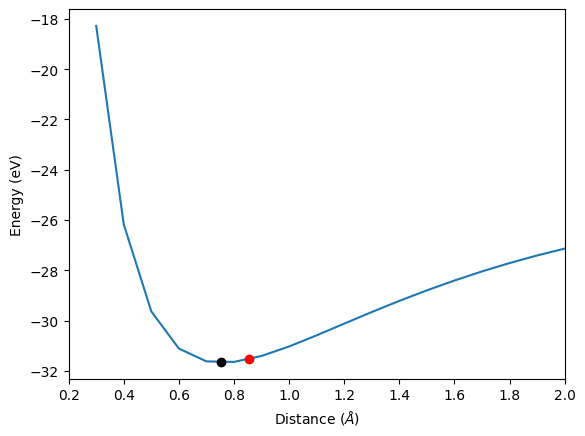

In [ ]:
plt.plot(distances, total_energies)
plt.plot(d0, energy0, marker='o', c='black')
plt.plot(d0+delta, displaced_h2.get_potential_energy(), marker='o', c='red')
plt.xlim(0.2,2.0)
plt.ylabel("Energy (eV)")
plt.xlabel("Distance ($\AA$)")

### Step 3: calculate the _force constant_

The force constant _C_ of a material is defined as the second order derivate with respect to atomic positions of the total energy.

For the $H_2$ molecule this means:
$
C = \frac{\partial^2 E}{\partial d^2}
= - \frac{\partial F}{\partial d}
= - \lim_{\delta d \rightarrow 0} \frac{F(d_0+\delta d) -F(d_0)}{\delta d}
\approx - \frac{F(d_0+\Delta d) -F(d_0)}{\Delta d}
\approx - \frac{F(d_0+\Delta d)}{\Delta d}
$

In [ ]:
d0 = 0.75358 # Angstrom
delta = 0.0025 # Angstrom
new_distance = d0 + delta # angstroms

# find the second hydrogen in the "atomic positions" line in the input file
distance_index = qe_input.find('ATOMIC_POSITIONS') + 49

# update the input file with the new atomic distance
new_input_file = qe_input[:distance_index] + "%.5f" % new_distance + qe_input[distance_index+8:]

# overwrite the input file
with open("h2.scf.in", "w") as f:
  f.write(new_input_file)

! /content/q-e/bin/pw.x  -in h2.scf.in > h2.scf.out # run the DFT input file

displaced_h2 = io.read("/content/hydrogen/h2.scf.out") # read the output file

In [ ]:
forces_1 = displaced_h2.get_forces() # extract force
force_constant = - forces_1[1][0] / delta
print("The force constant is :", force_constant, " eV/Angstrom^2")

The force constant is : 33.82306777496885  eV/Angstrom^2


### Step 4: calculate the vibrational _frequency_

In the classic harmonic model, atoms are subjected to the dynamics described by: $F = m \ddot{d} = - C~d$

The time solution is: $d(t) = A \sin(\omega t + \phi)$, where $\omega = \sqrt{\frac{C}{m}}$.

Let's calculae the oscillation frequency $\omega$ for the $H_2$ molecule!

In [ ]:
mass = 1 # atomic mass units
frequency = np.sqrt(force_constant / mass)
print("The oscillation frequency is: ", frequency, " (eV/(Angstrom^2 * AMU))^(1/2)")

The oscillation frequency is:  5.815760292082958  (eV/(Angstrom^2 * AMU))^(1/2)


Let's convert the angold frequency units to THz

In [ ]:
ev_to_joule = 1.60217733e-19
amu_to_kg = 1.6605402e-27
angstrom_to_m = 1.0e-10
hz_to_thz = 1.0e-12

conversion_factor = hz_to_thz * np.sqrt(ev_to_joule/amu_to_kg) / angstrom_to_m / (2.0*np.pi)
print("The conversion is: ", conversion_factor)

The conversion is:  15.633302300230191


In [ ]:
print("The oscillation frequency is: ", frequency * conversion_factor, " THz")

The oscillation frequency is:  90.91953875180792  THz


In [ ]:
thz_to_invcm = 33.3564095198152
print("The oscillation frequency is: ", frequency * conversion_factor * thz_to_invcm, " cm^(-1)")

The oscillation frequency is:  3032.749367958013  cm^(-1)


## $H_2$ vibrational mode: density-functional perturbation theory

### Step 1: compute the ground-state using DFT

This step should account also for the structural optimization, meaning forces on all atoms and stress tensor should be close to zero.

A DFT calculation is then needed to provide the ground-state charge density for the DFPT calculation.

In [ ]:
# update the input file with the relaxed atomic distance
new_input_file = qe_input[:distance_index] + "%.5f" % d0 + qe_input[distance_index+8:]

# overwrite the input file
with open("h2.scf.in", "w") as f:
  f.write(new_input_file)

! /content/q-e/bin/pw.x  -in h2.scf.in > h2.scf.out # run the DFT input file

ground_state = io.read("/content/hydrogen/h2.scf.out") # read the output file

ground_state_energy = ground_state.get_potential_energy() # eV
print('The ground state energy is ', ground_state_energy, ' eV')

The ground state energy is  -31.6792283295254  eV


### Step 2: compute the _dynamical matrix_ via DFPT

Run the density-functional perturbation theory calculation to compute the dynamical matrix.

Define the inputs using plain string text.

In [ ]:
ph_inputs = """
&INPUTPH
  tr2_ph=1.0e-21,
  prefix='h2',
  verbosity='high',
  ldisp=.false.
  qplot=.false.
  alpha_mix(1)=0.4
/
  0.0, 0.0, 0.0
"""

with open('h2.ph.in', 'w+') as handle:
    handle.write(ph_inputs)

Run the process using the `ph.x` executable.

In [ ]:
! /content/q-e/bin/ph.x  < h2.ph.in > h2.ph.out # run the ph.x executable

Read the results using ASE.

In [ ]:
from ase.io.espresso import read_espresso_ph

with open('h2.ph.out', 'r') as handle:
    ph_results = read_espresso_ph(handle)

ph_results[1]['freqs'][-1] * thz_to_invcm

4248.4190179327325

How does it compare with the value compute via finite differences?

Why are they different?

How does it compare with the experimental value 4161 $\mathrm{cm}^{-1}$?
(see _B. P. Stoicheff. 1957. HIGH RESOLUTION RAMAN SPECTROSCOPY OF GASES: IX. SPECTRA OF H2, HD, AND D2. Canadian Journal of Physics. 35(6): 730-741. https://doi.org/10.1139/p57-079_)

### Solution to discrepancy of finite differences and DFPT

The issue is that we did not use the correct formula! In fact, the calculation of frequencies involves a diagonalization of a (3N,3N) matrix. Look at the effect by diagonalizing the correct matrix, and then try to explain what should you modify in the previous section and why.

In [ ]:
from tabulate import tabulate

C = np.zeros((6,6))
C[2,5] = C[5,2] = C[2,2] = C[5,5] = force_constant

# Print the matrix as a nicely formatted table
print(tabulate(C, tablefmt="fancy_grid", floatfmt=".3f"))

╒═══════╤═══════╤════════╤═══════╤═══════╤════════╕
│ 0.000 │ 0.000 │  0.000 │ 0.000 │ 0.000 │  0.000 │
├───────┼───────┼────────┼───────┼───────┼────────┤
│ 0.000 │ 0.000 │  0.000 │ 0.000 │ 0.000 │  0.000 │
├───────┼───────┼────────┼───────┼───────┼────────┤
│ 0.000 │ 0.000 │ 33.823 │ 0.000 │ 0.000 │ 33.823 │
├───────┼───────┼────────┼───────┼───────┼────────┤
│ 0.000 │ 0.000 │  0.000 │ 0.000 │ 0.000 │  0.000 │
├───────┼───────┼────────┼───────┼───────┼────────┤
│ 0.000 │ 0.000 │  0.000 │ 0.000 │ 0.000 │  0.000 │
├───────┼───────┼────────┼───────┼───────┼────────┤
│ 0.000 │ 0.000 │ 33.823 │ 0.000 │ 0.000 │ 33.823 │
╘═══════╧═══════╧════════╧═══════╧═══════╧════════╛


Calculate the eigenvalues of the matrix using Numpy.

In [ ]:
np.sqrt(np.linalg.eigvals(C)) * thz_to_invcm * conversion_factor

array([4288.95528744,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ])

How does it compare with the force constants previously computed?

What are the other eigenvalues corresponding to?

Why are they zero?